In [163]:
# Importez les bibliothèques nécessaires
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
df = pd.read_csv('sentence_pairs_data.csv')
data = df.copy()
dataframe = df.copy()
df.columns


Index(['Numéro de paragraphe', 'Note de cohérence', 'phrase1', 'phrase2'], dtype='object')

In [174]:
# Exemple de nettoyage des données
df['phrase1'] = df['phrase1'].str.replace('[^a-zA-Z]', ' ')
df['phrase2'] = df['phrase2'].str.replace('[^a-zA-Z]', ' ')


<ipython-input-174-5c4f798080dc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['phrase1'] = df['phrase1'].str.replace('[^a-zA-Z]', ' ')
<ipython-input-174-5c4f798080dc>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['phrase2'] = df['phrase2'].str.replace('[^a-zA-Z]', ' ')


In [175]:
# Exemple d'application du lowercasing
df['phrase1'] = df['phrase1'].str.lower()
df['phrase2'] = df['phrase2'].str.lower()
df1=df
df2=df

In [63]:
df

,Numéro de paragraphe,Note de cohérence,phrase1,phrase2
0,1,4,in the realm of artificial intelligence algor...,concurrently traditional programming languag...
1,1,3,in the realm of artificial intelligence algor...,as quantum computing edges closer to reality ...
2,1,2,in the realm of artificial intelligence algor...,in the cybersecurity domain digital defenses...
3,1,2,in the realm of artificial intelligence algor...,while machine learning models analyze vast da...
4,1,4,concurrently traditional programming languag...,as quantum computing edges closer to reality ...
...,...,...,...,...
92,9,1,the cat caught a mouse,the school s science fair showcases projects ...
93,9,1,the cat caught a mouse,as the bell rings signaling the end of the d...
94,9,4,amid the chalkboard equations a glimpse of th...,the school s science fair showcases projects ...
95,9,3,amid the chalkboard equations a glimpse of th...,as the bell rings signaling the end of the d...


In [64]:
# Supprimer les doublons en se basant sur la colonne 'Numéro de paragraphe'
df_sans_doublons = df.drop_duplicates(subset='phrase1')
df_sans_doublons=df_sans_doublons.drop('phrase2',axis=1)

##DataFrame Paragraphe

In [65]:
import pandas as pd

# Grouper le dataframe par 'Numéro de paragraphe' et concaténer les phrases
df_groupe = df_sans_doublons.groupby('Numéro de paragraphe').agg({
    'phrase1': ' '.join,  # Concaténer les phrases de 'phrase1'

}).reset_index()



In [66]:
df_groupe.rename(columns={'phrase1': 'paragraphe'}, inplace=True)

df_groupe1=df_groupe
df_groupe2=df_groupe
df_groupe

,Numéro de paragraphe,paragraphe
0,1,in the realm of artificial intelligence algor...
1,2,the sun shines brightly in the clear blue sky ...
2,3,in computer science classes students code div...
3,4,leveraging the power of artificial intelligenc...
4,5,exploring new cultures is a pursuit that broad...
5,6,education is universally acknowledged as the k...
6,7,technology has revolutionized the fashion indu...
7,8,conversely fad diets that restrict entire foo...
8,9,in the bustling halls of the school students ...


#BERT

In [67]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

df['phrase1_embeddings'] = df['phrase1'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())
df['phrase2_embeddings'] = df['phrase2'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())
df_groupe['vectors']=df_groupe['paragraphe'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())

##Cosine distance

In [68]:
from sklearn.metrics.pairwise import cosine_similarity

df['cosine_similarity'] = df.apply(lambda row: cosine_similarity([row['phrase1_embeddings']], [row['phrase2_embeddings']])[0][0], axis=1)
# Scale similarity values to the range [1, 5]
min_val_cosine = df['cosine_similarity'].min()
max_val_cosine = df['cosine_similarity'].max()
df['cosine_similarity'] = 1 + 4 * (df['cosine_similarity'] - min_val_cosine) / (max_val_cosine - min_val_cosine)

# Round
df['cosine_similarity'] = df['cosine_similarity'].round()

In [69]:
vectors = df_groupe['vectors'].values

similarities = []
# Boucle pour comparer chaque paire de paragraphes
for i in range(1, 10):
    for j in range(i+1, 10):  # Assurez-vous que j > i pour avoir des paires distinctes
        vector_i = vectors[i-1]  # Soustraire 1 car les indices commencent à 0
        vector_j = vectors[j-1]

        # Calculer la similarité cosinus
        similarity = cosine_similarity([vector_i], [vector_j])[0][0]

        # Ajouter les informations à la liste
        similarities.append({
            'Paragraphe_i': i,
            'Paragraphe_j': j,
            'Similarité_cosinus': similarity
        })

# Créer un dataframe à partir de la liste
similarities_df = pd.DataFrame(similarities)
min_val_cosine = similarities_df['Similarité_cosinus'].min()
max_val_cosine = similarities_df['Similarité_cosinus'].max()
similarities_df['Similarité_cosinus'] = 1 + 4 * (similarities_df['Similarité_cosinus'] - min_val_cosine) / (max_val_cosine - min_val_cosine)

# Round the scaled similarity values to the nearest integer
similarities_df['Similarité_cosinus'] = similarities_df['Similarité_cosinus'].round()

In [70]:
similarities_df['Similarité_cosinus'].mean().round()

4.0

In [71]:
df['diff']=df['Note de cohérence']-df['cosine_similarity']
df['diff'].mean()

-0.7835051546391752

##Euclidean distance

In [72]:
import pandas as pd
import numpy as np

df['euclidean_distance'] = df.apply(lambda row: np.linalg.norm(row['phrase1_embeddings'] - row['phrase2_embeddings']), axis=1)
# Calculate similarity as the inverse of the Euclidean distance
df['euclidean_similarity'] = 1 / (1 + df['euclidean_distance'])
# Scale similarity values to the range [1, 5]
min_val = df['euclidean_similarity'].min()
max_val = df['euclidean_similarity'].max()
df['euclidean_similarity'] = 1 + 4 * (df['euclidean_similarity'] - min_val) / (max_val - min_val)
df['euclidean_similarity'] = df['euclidean_similarity'].round()



In [73]:
df['diff']=df['Note de cohérence']-df['euclidean_similarity']

df['diff'].mean()

-0.07216494845360824

In [74]:
from sklearn.metrics.pairwise import pairwise_distances
vectors = df_groupe['vectors'].values
distances = []
# Boucle pour comparer chaque paire de paragraphes
for i in range(1, 10):
    for j in range(i+1, 10):
        vector_i = vectors[i-1]
        vector_j = vectors[j-1]

        # Calculer la distance euclidienne
        distance = pairwise_distances([vector_i], [vector_j], metric='euclidean')[0][0]

        # Ajouter les informations à la liste
        distances.append({
            'Paragraphe_i': i,
            'Paragraphe_j': j,
            'Distance_euclidienne': distance
        })
distances_df = pd.DataFrame(distances)
# Calculate similarity as the inverse of the Euclidean distance
distances_df['Distance_euclidienne'] = 1 / (1 + distances_df['Distance_euclidienne'])
# Scale similarity values to the range [1, 5] based on min and max
min_val = distances_df['Distance_euclidienne'].min()
max_val = distances_df['Distance_euclidienne'].max()
distances_df['Distance_euclidienne'] = 1 + 4 * (distances_df['Distance_euclidienne'] - min_val) / (max_val - min_val)

distances_df['Distance_euclidienne'] = distances_df['Distance_euclidienne'].round()
similarities_df['Similarité_Distance_Euclidénne']=distances_df['Distance_euclidienne']


##Manhattan Distance (L1 Norm)

In [75]:
import pandas as pd
import numpy as np

df['manhattan_distance'] = df.apply(lambda row: np.linalg.norm(row['phrase1_embeddings'] - row['phrase2_embeddings'], ord=1), axis=1)

# Calculate similarity based on Manhattan distance
df['manhattan_similarity'] = 1 / (1 + df['manhattan_distance'])

# Scale similarity values to the range [1, 5]
min_val_manhattan = df['manhattan_similarity'].min()
max_val_manhattan = df['manhattan_similarity'].max()
df['manhattan_similarity'] = 1 + 4 * (df['manhattan_similarity'] - min_val_manhattan) / (max_val_manhattan - min_val_manhattan)

# Round the scaled similarity values to the nearest integer
df['manhattan_similarity'] = df['manhattan_similarity'].round()


In [76]:
df['diff']=df['Note de cohérence']-df['manhattan_similarity']
df['diff'].mean()

0.010309278350515464

In [77]:
vectors = df_groupe['vectors'].values

# Initialiser une liste pour stocker les paires de paragraphes et leur distance de Manhattan
distances = []

# Boucle pour comparer chaque paire de paragraphes
for i in range(1, 10):
    for j in range(i+1, 10):  # Assurez-vous que j > i pour avoir des paires distinctes
        vector_i = vectors[i-1]  # Soustraire 1 car les indices commencent à 0
        vector_j = vectors[j-1]

        # Calculer la distance de Manhattan
        distance = pairwise_distances([vector_i], [vector_j], metric='manhattan')[0][0]

        # Ajouter les informations à la liste
        distances.append({
            'Paragraphe_i': i,
            'Paragraphe_j': j,
            'Distance_manhattan': distance
        })

# Créer un dataframe à partir de la liste
distances_df = pd.DataFrame(distances)
# Calculate similarity as the inverse of the Euclidean distance
distances_df['Distance_manhattan'] = 1 / (1 + distances_df['Distance_manhattan'])
# Scale similarity values to the range [1, 5] based on min and max
min_val = distances_df['Distance_manhattan'].min()
max_val = distances_df['Distance_manhattan'].max()
distances_df['Distance_manhattan'] = 1 + 4 * (distances_df['Distance_manhattan'] - min_val) / (max_val - min_val)
# Round the scaled similarity values to the nearest integer
distances_df['Distance_manhattan'] = distances_df['Distance_manhattan'].round()
similarities_df['Similarité_Distance_Manhattan']=distances_df['Distance_manhattan']


###Cohérence entre les phrases

In [78]:
Similarités_Phrases = df.loc[:, ['Numéro de paragraphe', 'phrase1','phrase2','cosine_similarity','euclidean_similarity','manhattan_similarity','Note de cohérence']]
Similarités_Phrases

,Numéro de paragraphe,phrase1,phrase2,cosine_similarity,euclidean_similarity,manhattan_similarity,Note de cohérence
0,1,in the realm of artificial intelligence algor...,concurrently traditional programming languag...,4.0,3.0,3.0,4
1,1,in the realm of artificial intelligence algor...,as quantum computing edges closer to reality ...,5.0,4.0,4.0,3
2,1,in the realm of artificial intelligence algor...,in the cybersecurity domain digital defenses...,4.0,4.0,3.0,2
3,1,in the realm of artificial intelligence algor...,while machine learning models analyze vast da...,5.0,5.0,5.0,2
4,1,concurrently traditional programming languag...,as quantum computing edges closer to reality ...,3.0,3.0,3.0,4
...,...,...,...,...,...,...,...
92,9,the cat caught a mouse,the school s science fair showcases projects ...,1.0,2.0,2.0,1
93,9,the cat caught a mouse,as the bell rings signaling the end of the d...,1.0,1.0,1.0,1
94,9,amid the chalkboard equations a glimpse of th...,the school s science fair showcases projects ...,4.0,4.0,3.0,4
95,9,amid the chalkboard equations a glimpse of th...,as the bell rings signaling the end of the d...,5.0,4.0,4.0,3


###Cohérence des paragraphes selon BERT

In [79]:
Coherence_paragraphes=pd.DataFrame()
Coherence_paragraphes['cosine_similarity'] = Similarités_Phrases.groupby('Numéro de paragraphe')['cosine_similarity'].mean().round()
Coherence_paragraphes['manhattan_similarity'] = Similarités_Phrases.groupby('Numéro de paragraphe')['manhattan_similarity'].mean().round()
Coherence_paragraphes['euclidean_similarity'] = Similarités_Phrases.groupby('Numéro de paragraphe')['euclidean_similarity'].mean().round()
Coherence_paragraphes

,cosine_similarity,manhattan_similarity,euclidean_similarity
Numéro de paragraphe,,,
1,4.0,4.0,4.0
2,3.0,2.0,2.0
3,3.0,2.0,3.0
4,4.0,3.0,3.0
5,3.0,2.0,2.0
6,4.0,2.0,3.0
7,3.0,2.0,2.0
8,3.0,3.0,3.0
9,3.0,3.0,3.0


###Cohérence entre les paragraphes:
On suppose que chaque paragraphe est une phrase et on traite la coherence de la meme manière qu'on a traité la coherence entre les phrases.

In [80]:
similarities_df

,Paragraphe_i,Paragraphe_j,Similarité_cosinus,Similarité_Distance_Euclidénne,Similarité_Distance_Manhattan
0,1,2,3.0,2.0,2.0
1,1,3,5.0,5.0,5.0
2,1,4,4.0,3.0,3.0
3,1,5,4.0,4.0,4.0
4,1,6,3.0,2.0,2.0
5,1,7,4.0,4.0,4.0
6,1,8,4.0,3.0,3.0
7,1,9,5.0,4.0,4.0
8,2,3,2.0,2.0,2.0
9,2,4,2.0,1.0,1.0


###Cohérence du texte selon BERT

####A partir des notes de cohérences entre les paragraphes

In [81]:
print('Coherence du texte selon Distance Euclideinne',similarities_df['Similarité_Distance_Euclidénne'].mean().round(),'\n')
print('Coherence du texte selon Distance de Manhattan',similarities_df['Similarité_Distance_Manhattan'].mean().round(),'\n')
print('Coherence du texte selon Cosine',similarities_df['Similarité_cosinus'].mean().round(),'\n')

Coherence du texte selon Distance Euclideinne 3.0 

Coherence du texte selon Distance de Manhattan 3.0 

Coherence du texte selon Cosine 4.0 



####A partir des notes de cohérences entre les phrases

In [82]:
print('Coherence du texte selon Distance Euclideinne',Similarités_Phrases['euclidean_similarity'].mean().round(),'\n')
print('Coherence du texte selon Distance de Manhattan',Similarités_Phrases['manhattan_similarity'].mean().round(),'\n')
print('Coherence du texte selon Cosine',Similarités_Phrases['cosine_similarity'].mean().round(),'\n')


Coherence du texte selon Distance Euclideinne 3.0 

Coherence du texte selon Distance de Manhattan 3.0 

Coherence du texte selon Cosine 3.0 



#GPT2

In [83]:
from transformers import GPT2Tokenizer, GPT2Model

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

df1['phrase1_embeddings'] = df1['phrase1'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())
df1['phrase2_embeddings'] = df1['phrase2'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())
df_groupe1['vectors'] = df_groupe1['paragraphe'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())

##Cosine distance

In [84]:
# Calculate cosine similarity
df1['cosine_similarity'] = df1.apply(lambda row: cosine_similarity([row['phrase1_embeddings']], [row['phrase2_embeddings']])[0, 0], axis=1)
# Scale similarity values to the range [1, 5] based on min and max
min_val_cosine = df1['cosine_similarity'].min()
max_val_cosine = df1['cosine_similarity'].max()
df1['cosine_similarity'] = 1 + 4 * (df1['cosine_similarity'] - min_val_cosine) / (max_val_cosine - min_val_cosine)
# Round the scaled similarity values to the nearest integer
df1['cosine_similarity'] = df1['cosine_similarity'].round()

In [85]:
vectors = df_groupe1['vectors'].values

similarities = []
# Boucle pour comparer chaque paire de paragraphes
for i in range(1, 10):
    for j in range(i+1, 10):  # Assurez-vous que j > i pour avoir des paires distinctes
        vector_i = vectors[i-1]  # Soustraire 1 car les indices commencent à 0
        vector_j = vectors[j-1]

        # Calculer la similarité cosinus
        similarity = cosine_similarity([vector_i], [vector_j])[0][0]

        # Ajouter les informations à la liste
        similarities.append({
            'Paragraphe_i': i,
            'Paragraphe_j': j,
            'Similarité_cosinus': similarity
        })

# Créer un dataframe à partir de la liste
similarities_df = pd.DataFrame(similarities)
min_val_cosine = similarities_df['Similarité_cosinus'].min()
max_val_cosine = similarities_df['Similarité_cosinus'].max()
similarities_df['Similarité_cosinus'] = 1 + 4 * (similarities_df['Similarité_cosinus'] - min_val_cosine) / (max_val_cosine - min_val_cosine)

# Round the scaled similarity values to the nearest integer
similarities_df['Similarité_cosinus'] = similarities_df['Similarité_cosinus'].round()


In [86]:
df1['diff']=df1['Note de cohérence']-df1['cosine_similarity']
df1['diff'].mean()

-1.6288659793814433

##Euclidean Distance

In [87]:
# Assuming 'phrase1_embeddings' and 'phrase2_embeddings' are columns in your DataFrame df1
df1['euclidean_distance'] = df1.apply(lambda row: np.linalg.norm(row['phrase1_embeddings'] - row['phrase2_embeddings']), axis=1)

# Calculate similarity as the inverse of the Euclidean distance
df1['euclidean_similarity'] = 1 / (1 + df1['euclidean_distance'])

# Scale similarity values to the range [1, 5] based on min and max
min_val_euclidean = df1['euclidean_similarity'].min()
max_val_euclidean = df1['euclidean_similarity'].max()
df1['euclidean_similarity'] = 1 + 4 * (df1['euclidean_similarity'] - min_val_euclidean) / (max_val_euclidean - min_val_euclidean)

# Round the scaled similarity values to the nearest integer
df1['euclidean_similarity'] = df1['euclidean_similarity'].round()
df1['diff']=df1['Note de cohérence']-df1['euclidean_similarity']
df1['diff'].mean()

-0.08247422680412371

In [88]:
from sklearn.metrics.pairwise import pairwise_distances
vectors = df_groupe1['vectors'].values
distances = []
# Boucle pour comparer chaque paire de paragraphes
for i in range(1, 10):
    for j in range(i+1, 10):
        vector_i = vectors[i-1]
        vector_j = vectors[j-1]

        # Calculer la distance euclidienne
        distance = pairwise_distances([vector_i], [vector_j], metric='euclidean')[0][0]

        # Ajouter les informations à la liste
        distances.append({
            'Paragraphe_i': i,
            'Paragraphe_j': j,
            'Distance_euclidienne': distance
        })
distances_df = pd.DataFrame(distances)
# Calculate similarity as the inverse of the Euclidean distance
distances_df['Distance_euclidienne'] = 1 / (1 + distances_df['Distance_euclidienne'])
# Scale similarity values to the range [1, 5] based on min and max
min_val = distances_df['Distance_euclidienne'].min()
max_val = distances_df['Distance_euclidienne'].max()
distances_df['Distance_euclidienne'] = 1 + 4 * (distances_df['Distance_euclidienne'] - min_val) / (max_val - min_val)

distances_df['Distance_euclidienne'] = distances_df['Distance_euclidienne'].round()
similarities_df['Similarité_Distance_Euclidénne']=distances_df['Distance_euclidienne']


##Manhattan Distance(L1 Norm)

In [89]:
# Assuming 'phrase1_embeddings' and 'phrase2_embeddings' are columns in your DataFrame df1
df1['manhattan_distance'] = df1.apply(lambda row: np.linalg.norm(row['phrase1_embeddings'] - row['phrase2_embeddings'], ord=1), axis=1)

# Calculate similarity as the inverse of the Manhattan distance
df1['manhattan_similarity'] = 1 / (1 + df1['manhattan_distance'])

# Scale similarity values to the range [1, 5] based on min and max
min_val_manhattan = df1['manhattan_similarity'].min()
max_val_manhattan = df1['manhattan_similarity'].max()
df1['manhattan_similarity'] = 1 + 4 * (df1['manhattan_similarity'] - min_val_manhattan) / (max_val_manhattan - min_val_manhattan)

# Round the scaled similarity values to the nearest integer
df1['manhattan_similarity'] = df1['manhattan_similarity'].round()
df1['diff']=df1['Note de cohérence']-df1['manhattan_similarity']
df1['diff'].mean()

-0.32989690721649484

In [90]:
vectors = df_groupe1['vectors'].values

# Initialiser une liste pour stocker les paires de paragraphes et leur distance de Manhattan
distances = []

# Boucle pour comparer chaque paire de paragraphes
for i in range(1, 10):
    for j in range(i+1, 10):  # Assurez-vous que j > i pour avoir des paires distinctes
        vector_i = vectors[i-1]  # Soustraire 1 car les indices commencent à 0
        vector_j = vectors[j-1]

        # Calculer la distance de Manhattan
        distance = pairwise_distances([vector_i], [vector_j], metric='manhattan')[0][0]

        # Ajouter les informations à la liste
        distances.append({
            'Paragraphe_i': i,
            'Paragraphe_j': j,
            'Distance_manhattan': distance
        })

# Créer un dataframe à partir de la liste
distances_df = pd.DataFrame(distances)
# Calculate similarity as the inverse of the Euclidean distance
distances_df['Distance_manhattan'] = 1 / (1 + distances_df['Distance_manhattan'])
# Scale similarity values to the range [1, 5] based on min and max
min_val = distances_df['Distance_manhattan'].min()
max_val = distances_df['Distance_manhattan'].max()
distances_df['Distance_manhattan'] = 1 + 4 * (distances_df['Distance_manhattan'] - min_val) / (max_val - min_val)
# Round the scaled similarity values to the nearest integer
distances_df['Distance_manhattan'] = distances_df['Distance_manhattan'].round()
similarities_df['Similarité_Distance_Manhattan']=distances_df['Distance_manhattan']


###Cohérence entre les phrases

In [91]:
Similarités_Phrases = df1.loc[:, ['Numéro de paragraphe', 'phrase1','phrase2','cosine_similarity','euclidean_similarity','manhattan_similarity','Note de cohérence']]
Similarités_Phrases

,Numéro de paragraphe,phrase1,phrase2,cosine_similarity,euclidean_similarity,manhattan_similarity,Note de cohérence
0,1,in the realm of artificial intelligence algor...,concurrently traditional programming languag...,5.0,1.0,2.0,4
1,1,in the realm of artificial intelligence algor...,as quantum computing edges closer to reality ...,5.0,1.0,3.0,3
2,1,in the realm of artificial intelligence algor...,in the cybersecurity domain digital defenses...,5.0,2.0,3.0,2
3,1,in the realm of artificial intelligence algor...,while machine learning models analyze vast da...,4.0,1.0,2.0,2
4,1,concurrently traditional programming languag...,as quantum computing edges closer to reality ...,5.0,4.0,3.0,4
...,...,...,...,...,...,...,...
92,9,the cat caught a mouse,the school s science fair showcases projects ...,3.0,1.0,1.0,1
93,9,the cat caught a mouse,as the bell rings signaling the end of the d...,2.0,1.0,2.0,1
94,9,amid the chalkboard equations a glimpse of th...,the school s science fair showcases projects ...,5.0,4.0,5.0,4
95,9,amid the chalkboard equations a glimpse of th...,as the bell rings signaling the end of the d...,5.0,2.0,4.0,3


###Cohérence des paragraphes selon GPT-2

In [92]:
Coherence_paragraphes=pd.DataFrame()
Coherence_paragraphes['cosine_similarity'] = Similarités_Phrases.groupby('Numéro de paragraphe')['cosine_similarity'].mean().round()
Coherence_paragraphes['manhattan_similarity'] = Similarités_Phrases.groupby('Numéro de paragraphe')['manhattan_similarity'].mean().round()
Coherence_paragraphes['euclidean_similarity'] = Similarités_Phrases.groupby('Numéro de paragraphe')['euclidean_similarity'].mean().round()
Coherence_paragraphes

,cosine_similarity,manhattan_similarity,euclidean_similarity
Numéro de paragraphe,,,
1,5.0,3.0,2.0
2,4.0,3.0,2.0
3,4.0,3.0,3.0
4,3.0,3.0,2.0
5,4.0,3.0,3.0
6,4.0,2.0,2.0
7,4.0,2.0,2.0
8,5.0,3.0,3.0
9,4.0,3.0,3.0


###Cohérence entre les paragraphes:
On suppose que chaque paragraphe est une phrase et on traite la coherence de la meme manière qu'on a traité la coherence entre les phrases.

In [93]:
similarities_df

,Paragraphe_i,Paragraphe_j,Similarité_cosinus,Similarité_Distance_Euclidénne,Similarité_Distance_Manhattan
0,1,2,4.0,2.0,2.0
1,1,3,5.0,2.0,3.0
2,1,4,4.0,3.0,5.0
3,1,5,5.0,5.0,5.0
4,1,6,3.0,3.0,3.0
5,1,7,5.0,1.0,2.0
6,1,8,5.0,2.0,4.0
7,1,9,4.0,2.0,4.0
8,2,3,4.0,3.0,2.0
9,2,4,3.0,2.0,2.0


###Cohérence du texte selon GPT-2

####A partir des notes de cohérences entre les paragraphes

In [94]:
print('Coherence du texte selon Distance Euclideinne',similarities_df['Similarité_Distance_Euclidénne'].mean().round(),'\n')
print('Coherence du texte selon Distance de Manhattan',similarities_df['Similarité_Distance_Manhattan'].mean().round(),'\n')
print('Coherence du texte selon Cosine',similarities_df['Similarité_cosinus'].mean().round(),'\n')

Coherence du texte selon Distance Euclideinne 2.0 

Coherence du texte selon Distance de Manhattan 3.0 

Coherence du texte selon Cosine 4.0 



####A partir des notes de cohérences entre les phrases

In [95]:
print('Coherence du texte selon Distance Euclideinne',Similarités_Phrases['euclidean_similarity'].mean().round(),'\n')
print('Coherence du texte selon Distance de Manhattan',Similarités_Phrases['manhattan_similarity'].mean().round(),'\n')
print('Coherence du texte selon Cosine',Similarités_Phrases['cosine_similarity'].mean().round(),'\n')


Coherence du texte selon Distance Euclideinne 3.0 

Coherence du texte selon Distance de Manhattan 3.0 

Coherence du texte selon Cosine 4.0 



#Roberta

In [96]:
from transformers import RobertaTokenizer, RobertaModel
import torch
import pandas as pd

# Charger le tokenizer et le modèle RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')


df2['phrase1_embeddings'] = df2['phrase1'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())
df2['phrase2_embeddings'] = df2['phrase2'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())
df_groupe2['vectors']=df_groupe2['paragraphe'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Cosine distance

In [97]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Assuming 'phrase1_embeddings' and 'phrase2_embeddings' are columns in your DataFrame df2
# Assuming the embeddings are in NumPy array format

# Calculate cosine similarity
df2['cosine_similarity'] = df2.apply(lambda row: cosine_similarity([row['phrase1_embeddings']], [row['phrase2_embeddings']])[0, 0], axis=1)

# Scale similarity values to the range [1, 5] based on min and max
min_val_cosine = df2['cosine_similarity'].min()
max_val_cosine = df2['cosine_similarity'].max()
df2['cosine_similarity'] = 1 + 4 * (df2['cosine_similarity'] - min_val_cosine) / (max_val_cosine - min_val_cosine)

# Round the scaled similarity values to the nearest integer
df2['cosine_similarity'] = df2['cosine_similarity'].round()
df2['diff']=df2['Note de cohérence']-df2['cosine_similarity']
df2['diff'].mean()

-1.309278350515464

In [98]:
vectors = df_groupe2['vectors'].values

similarities = []
# Boucle pour comparer chaque paire de paragraphes
for i in range(1, 10):
    for j in range(i+1, 10):  # Assurez-vous que j > i pour avoir des paires distinctes
        vector_i = vectors[i-1]  # Soustraire 1 car les indices commencent à 0
        vector_j = vectors[j-1]

        # Calculer la similarité cosinus
        similarity = cosine_similarity([vector_i], [vector_j])[0][0]

        # Ajouter les informations à la liste
        similarities.append({
            'Paragraphe_i': i,
            'Paragraphe_j': j,
            'Similarité_cosinus': similarity
        })

# Créer un dataframe à partir de la liste
similarities_df = pd.DataFrame(similarities)
min_val_cosine = similarities_df['Similarité_cosinus'].min()
max_val_cosine = similarities_df['Similarité_cosinus'].max()
similarities_df['Similarité_cosinus'] = 1 + 4 * (similarities_df['Similarité_cosinus'] - min_val_cosine) / (max_val_cosine - min_val_cosine)

# Round the scaled similarity values to the nearest integer
similarities_df['Similarité_cosinus'] = similarities_df['Similarité_cosinus'].round()

##Euclidean distance

In [99]:
import pandas as pd
import numpy as np

# Assuming 'phrase1_embeddings' and 'phrase2_embeddings' are columns in your DataFrame df2
df2['euclidean_distance'] = df2.apply(lambda row: np.linalg.norm(row['phrase1_embeddings'] - row['phrase2_embeddings']), axis=1)

# Calculate similarity as the inverse of the Euclidean distance
df2['euclidean_similarity'] = 1 / (1 + df2['euclidean_distance'])

# Scale similarity values to the range [1, 5] based on min and max
min_val_euclidean = df2['euclidean_similarity'].min()
max_val_euclidean = df2['euclidean_similarity'].max()
df2['euclidean_similarity'] = 1 + 4 * (df2['euclidean_similarity'] - min_val_euclidean) / (max_val_euclidean - min_val_euclidean)

# Round the scaled similarity values to the nearest integer
df2['euclidean_similarity'] = df2['euclidean_similarity'].round()
df2['diff']=df2['Note de cohérence']-df2['euclidean_similarity']
df2['diff'].mean()

-0.35051546391752575

In [100]:
from sklearn.metrics.pairwise import pairwise_distances
vectors = df_groupe2['vectors'].values
distances = []
# Boucle pour comparer chaque paire de paragraphes
for i in range(1, 10):
    for j in range(i+1, 10):
        vector_i = vectors[i-1]
        vector_j = vectors[j-1]

        # Calculer la distance euclidienne
        distance = pairwise_distances([vector_i], [vector_j], metric='euclidean')[0][0]

        # Ajouter les informations à la liste
        distances.append({
            'Paragraphe_i': i,
            'Paragraphe_j': j,
            'Distance_euclidienne': distance
        })
distances_df = pd.DataFrame(distances)
# Calculate similarity as the inverse of the Euclidean distance
distances_df['Distance_euclidienne'] = 1 / (1 + distances_df['Distance_euclidienne'])
# Scale similarity values to the range [1, 5] based on min and max
min_val = distances_df['Distance_euclidienne'].min()
max_val = distances_df['Distance_euclidienne'].max()
distances_df['Distance_euclidienne'] = 1 + 4 * (distances_df['Distance_euclidienne'] - min_val) / (max_val - min_val)

distances_df['Distance_euclidienne'] = distances_df['Distance_euclidienne'].round()
similarities_df['Similarité_Distance_Euclidénne']=distances_df['Distance_euclidienne']


##Manhattan Distance (L1 Norm)

In [101]:
import pandas as pd
import numpy as np

# Assuming 'phrase1_embeddings' and 'phrase2_embeddings' are columns in your DataFrame df2
df2['manhattan_distance'] = df2.apply(lambda row: np.linalg.norm(row['phrase1_embeddings'] - row['phrase2_embeddings'], ord=1), axis=1)

# Calculate similarity as the inverse of the Manhattan distance
df2['manhattan_similarity'] = 1 / (1 + df2['manhattan_distance'])

# Scale similarity values to the range [1, 5] based on min and max
min_val_manhattan = df2['manhattan_similarity'].min()
max_val_manhattan = df2['manhattan_similarity'].max()
df2['manhattan_similarity'] = 1 + 4 * (df2['manhattan_similarity'] - min_val_manhattan) / (max_val_manhattan - min_val_manhattan)

# Round the scaled similarity values to the nearest integer
df2['manhattan_similarity'] = df2['manhattan_similarity'].round()


In [102]:
vectors = df_groupe2['vectors'].values

# Initialiser une liste pour stocker les paires de paragraphes et leur distance de Manhattan
distances = []

# Boucle pour comparer chaque paire de paragraphes
for i in range(1, 10):
    for j in range(i+1, 10):  # Assurez-vous que j > i pour avoir des paires distinctes
        vector_i = vectors[i-1]  # Soustraire 1 car les indices commencent à 0
        vector_j = vectors[j-1]

        # Calculer la distance de Manhattan
        distance = pairwise_distances([vector_i], [vector_j], metric='manhattan')[0][0]

        # Ajouter les informations à la liste
        distances.append({
            'Paragraphe_i': i,
            'Paragraphe_j': j,
            'Distance_manhattan': distance
        })

# Créer un dataframe à partir de la liste
distances_df = pd.DataFrame(distances)
# Calculate similarity as the inverse of the Euclidean distance
distances_df['Distance_manhattan'] = 1 / (1 + distances_df['Distance_manhattan'])
# Scale similarity values to the range [1, 5] based on min and max
min_val = distances_df['Distance_manhattan'].min()
max_val = distances_df['Distance_manhattan'].max()
distances_df['Distance_manhattan'] = 1 + 4 * (distances_df['Distance_manhattan'] - min_val) / (max_val - min_val)
# Round the scaled similarity values to the nearest integer
distances_df['Distance_manhattan'] = distances_df['Distance_manhattan'].round()
similarities_df['Similarité_Distance_Manhattan']=distances_df['Distance_manhattan']


In [103]:
df2['diff']=df2['Note de cohérence']-df2['manhattan_similarity']
df2['diff'].mean()

0.08247422680412371

###Cohérence entre les phrases

In [104]:
Similarités_Phrases = df2.loc[:, ['Numéro de paragraphe', 'phrase1','phrase2','cosine_similarity','euclidean_similarity','manhattan_similarity','Note de cohérence']]
Similarités_Phrases

,Numéro de paragraphe,phrase1,phrase2,cosine_similarity,euclidean_similarity,manhattan_similarity,Note de cohérence
0,1,in the realm of artificial intelligence algor...,concurrently traditional programming languag...,4.0,3.0,3.0,4
1,1,in the realm of artificial intelligence algor...,as quantum computing edges closer to reality ...,4.0,3.0,3.0,3
2,1,in the realm of artificial intelligence algor...,in the cybersecurity domain digital defenses...,5.0,4.0,4.0,2
3,1,in the realm of artificial intelligence algor...,while machine learning models analyze vast da...,5.0,4.0,4.0,2
4,1,concurrently traditional programming languag...,as quantum computing edges closer to reality ...,4.0,2.0,2.0,4
...,...,...,...,...,...,...,...
92,9,the cat caught a mouse,the school s science fair showcases projects ...,2.0,2.0,2.0,1
93,9,the cat caught a mouse,as the bell rings signaling the end of the d...,1.0,1.0,1.0,1
94,9,amid the chalkboard equations a glimpse of th...,the school s science fair showcases projects ...,5.0,4.0,4.0,4
95,9,amid the chalkboard equations a glimpse of th...,as the bell rings signaling the end of the d...,5.0,4.0,4.0,3


###Cohérence des paragraphes selon



ROBERTA

In [105]:
Coherence_paragraphes=pd.DataFrame()
Coherence_paragraphes['cosine_similarity'] = Similarités_Phrases.groupby('Numéro de paragraphe')['cosine_similarity'].mean().round()
Coherence_paragraphes['manhattan_similarity'] = Similarités_Phrases.groupby('Numéro de paragraphe')['manhattan_similarity'].mean().round()
Coherence_paragraphes['euclidean_similarity'] = Similarités_Phrases.groupby('Numéro de paragraphe')['euclidean_similarity'].mean().round()
Coherence_paragraphes

,cosine_similarity,manhattan_similarity,euclidean_similarity
Numéro de paragraphe,,,
1,4.0,3.0,3.0
2,4.0,2.0,3.0
3,4.0,2.0,3.0
4,4.0,3.0,3.0
5,4.0,2.0,2.0
6,4.0,3.0,3.0
7,4.0,2.0,3.0
8,4.0,3.0,4.0
9,3.0,3.0,3.0


###Cohérence entre les paragraphes:
On suppose que chaque paragraphe est une phrase et on traite la coherence de la meme manière qu'on a traité la coherence entre les phrases.

In [106]:
similarities_df

,Paragraphe_i,Paragraphe_j,Similarité_cosinus,Similarité_Distance_Euclidénne,Similarité_Distance_Manhattan
0,1,2,3.0,2.0,2.0
1,1,3,5.0,5.0,5.0
2,1,4,4.0,3.0,3.0
3,1,5,4.0,3.0,3.0
4,1,6,3.0,2.0,2.0
5,1,7,5.0,4.0,4.0
6,1,8,5.0,4.0,4.0
7,1,9,5.0,4.0,4.0
8,2,3,3.0,2.0,2.0
9,2,4,2.0,1.0,1.0


###Cohérence du texte selon roBERTa

In [107]:
print('Coherence du texte selon Distance Euclideinne',similarities_df['Similarité_Distance_Euclidénne'].mean().round(),'\n')
print('Coherence du texte selon Distance de Manhattan',similarities_df['Similarité_Distance_Manhattan'].mean().round(),'\n')
print('Coherence du texte selon Cosine',similarities_df['Similarité_cosinus'].mean().round(),'\n')

Coherence du texte selon Distance Euclideinne 3.0 

Coherence du texte selon Distance de Manhattan 3.0 

Coherence du texte selon Cosine 4.0 



####A partir des notes de cohérences entre les phrases

In [108]:
print('Coherence du texte selon Distance Euclideinne',Similarités_Phrases['euclidean_similarity'].mean().round(),'\n')
print('Coherence du texte selon Distance de Manhattan',Similarités_Phrases['manhattan_similarity'].mean().round(),'\n')
print('Coherence du texte selon Cosine',Similarités_Phrases['cosine_similarity'].mean().round(),'\n')


Coherence du texte selon Distance Euclideinne 3.0 

Coherence du texte selon Distance de Manhattan 2.0 

Coherence du texte selon Cosine 4.0 



# ***Approche matricielle***

# Etape 2

In [109]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string

# Téléchargez les ressources nécessaires pour NLTK (à exécuter une fois)
nltk.download('punkt')
nltk.download('stopwords')

# Texte du corpus
corpus = """
Leveraging the power of artificial intelligence is transforming industries worldwide. From healthcare to manufacturing, AI applications are enhancing efficiency and accuracy. Climate change is undeniably a pressing global concern. The impact of deforestation on biodiversity is a topic that demands our attention.

Exploring new cultures is a pursuit that broadens our understanding of the world. Planning a trip involves careful consideration of both budget constraints and the desired itinerary. In the field of healthcare, for instance, AI aids in diagnosing diseases with unprecedented precision. Sustainable practices, such as recycling and embracing renewable energy sources, play a pivotal role in mitigating environmental degradation.

Education is universally acknowledged as the key to personal and societal development. The rise of online learning platforms has provided learners with unprecedented flexibility. However, it is essential to recognize that the role of educators extends beyond imparting knowledge; it includes nurturing critical thinking skills and fostering a passion for lifelong learning.
"""

# Tokenisation des phrases
sentences = sent_tokenize(corpus)

# Suppression de la ponctuation inutile et normalisation du texte
translator = str.maketrans('', '', string.punctuation)
normalized_sentences = [sentence.translate(translator).lower() for sentence in sentences]

# Suppression des mots vides (stop words)
stop_words = set(stopwords.words('english'))
filtered_sentences = [' '.join([word for word in sentence.split() if word not in stop_words]) for sentence in normalized_sentences]

# Affichage des résultats avec le nombre de phrases
for i, (original, processed) in enumerate(zip(sentences, filtered_sentences), 1):
    print(f"Original (Sentence {i}): {original}")
    print(f"Processed: {processed}\n")

# Affichage du nombre total de phrases
print(f"Nombre total de phrases: {len(sentences)}")


Original (Sentence 1): 
Leveraging the power of artificial intelligence is transforming industries worldwide.
Processed: leveraging power artificial intelligence transforming industries worldwide

Original (Sentence 2): From healthcare to manufacturing, AI applications are enhancing efficiency and accuracy.
Processed: healthcare manufacturing ai applications enhancing efficiency accuracy

Original (Sentence 3): Climate change is undeniably a pressing global concern.
Processed: climate change undeniably pressing global concern

Original (Sentence 4): The impact of deforestation on biodiversity is a topic that demands our attention.
Processed: impact deforestation biodiversity topic demands attention

Original (Sentence 5): Exploring new cultures is a pursuit that broadens our understanding of the world.
Processed: exploring new cultures pursuit broadens understanding world

Original (Sentence 6): Planning a trip involves careful consideration of both budget constraints and the desired i

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# ***Annotation Humaine***

In [110]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import string
import numpy as np

# Téléchargez les ressources nécessaires pour NLTK (à exécuter une fois)
nltk.download('punkt')
nltk.download('stopwords')

# Texte du corpus
corpus = """
Leveraging the power of artificial intelligence is transforming industries worldwide. From healthcare to manufacturing, AI applications are enhancing efficiency and accuracy. Climate change is undeniably a pressing global concern. The impact of deforestation on biodiversity is a topic that demands our attention.

Exploring new cultures is a pursuit that broadens our understanding of the world. Planning a trip involves careful consideration of both budget constraints and the desired itinerary. In the field of healthcare, for instance, AI aids in diagnosing diseases with unprecedented precision. Sustainable practices, such as recycling and embracing renewable energy sources, play a pivotal role in mitigating environmental degradation.

Education is universally acknowledged as the key to personal and societal development. The rise of online learning platforms has provided learners with unprecedented flexibility. However, it is essential to recognize that the role of educators extends beyond imparting knowledge; it includes nurturing critical thinking skills and fostering a passion for lifelong learning.
"""

# Tokenisation des phrases
sentences = sent_tokenize(corpus)

# Suppression de la ponctuation inutile et normalisation du texte
translator = str.maketrans('', '', string.punctuation)
normalized_sentences = [sentence.translate(translator).lower() for sentence in sentences]

# Suppression des mots vides (stop words)
stop_words = set(stopwords.words('english'))
filtered_sentences = [' '.join([word for word in sentence.split() if word not in stop_words]) for sentence in normalized_sentences]

# Créer une matrice d'annotations de cohérence avec des valeurs initiales de 5
coherence_matrix = np.full((len(sentences), len(sentences)), 5, dtype=int)


# Remplir la matrice avec les annotations de l'utilisateur
for i in range(len(sentences)):
    for j in range(i + 1, len(sentences)):
        annotation = int(input(f"Entrez l'annotation de cohérence entre la phrase {i + 1} et la phrase {j + 1} (un entier) : "))
        coherence_matrix[i, j] = annotation
        coherence_matrix[j, i] = annotation

# Afficher la matrice d'annotations de cohérence
print("Matrice d'annotations de cohérence:")
print(coherence_matrix)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Entrez l'annotation de cohérence entre la phrase 1 et la phrase 2 (un entier) : 5
Entrez l'annotation de cohérence entre la phrase 1 et la phrase 3 (un entier) : 2
Entrez l'annotation de cohérence entre la phrase 1 et la phrase 4 (un entier) : 1
Entrez l'annotation de cohérence entre la phrase 1 et la phrase 5 (un entier) : 1
Entrez l'annotation de cohérence entre la phrase 1 et la phrase 6 (un entier) : 1
Entrez l'annotation de cohérence entre la phrase 1 et la phrase 7 (un entier) : 5
Entrez l'annotation de cohérence entre la phrase 1 et la phrase 8 (un entier) : 2
Entrez l'annotation de cohérence entre la phrase 1 et la phrase 9 (un entier) : 1
Entrez l'annotation de cohérence entre la phrase 1 et la phrase 10 (un entier) : 1
Entrez l'annotation de cohérence entre la phrase 1 et la phrase 11 (un entier) : 1
Entrez l'annotation de cohérence entre la phrase 2 et la phrase 3 (un entier) : 2
Entrez l'annotation de cohérence entre la phrase 2 et la phrase 4 (un entier) : 1
Entrez l'annot

# BERT

In [111]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
# Utilisation du modèle BERT pour générer des représentations vectorielles
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Liste pour stocker les représentations vectorielles
embeddings = []

# Boucle à travers chaque phrase
for sentence in filtered_sentences:
    tokens = tokenizer(sentence, return_tensors='pt')
    outputs = model(**tokens)
    embeddings.append(outputs['last_hidden_state'].mean(dim=1).squeeze().detach().numpy())

# Création de la matrice de similarité cosinus
cosine_sim_matrix = cosine_similarity(embeddings)

# Affichage de la matrice de similarité cosinus
print("Cosine Similarity Matrix:")
print(cosine_sim_matrix)

Cosine Similarity Matrix:
[[0.99999964 0.7846193  0.6813915  0.66152537 0.7296316  0.49179944
  0.72412866 0.7209128  0.6810623  0.70640475 0.6795249 ]
 [0.7846193  1.0000001  0.5449951  0.6861123  0.629315   0.5140544
  0.78687274 0.66922367 0.68860084 0.6930936  0.64296854]
 [0.6813915  0.5449951  0.99999976 0.6654651  0.6401696  0.5224975
  0.595362   0.7119024  0.6191478  0.5362478  0.56441176]
 [0.66152537 0.6861123  0.6654651  0.99999976 0.68055636 0.6240201
  0.6961787  0.7137266  0.6787304  0.6418749  0.61685467]
 [0.7296316  0.629315   0.6401696  0.68055636 0.99999964 0.5908185
  0.6652982  0.6236777  0.7088858  0.6788551  0.7205054 ]
 [0.49179944 0.5140544  0.5224975  0.6240201  0.5908185  1.0000002
  0.5321306  0.5445465  0.5653581  0.5089979  0.60203075]
 [0.72412866 0.78687274 0.595362   0.6961787  0.6652982  0.5321306
  0.9999999  0.6254647  0.6677863  0.6504685  0.6722281 ]
 [0.7209128  0.66922367 0.7119024  0.7137266  0.6236777  0.5445465
  0.6254647  1.         0.65657

# ***Annotation Automatique***

In [112]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Création de la matrice de similarité cosinus
# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings, dtype=object)


In [113]:
normalized_similarity_matrix = (4*cosine_sim_matrix+1).round()

In [114]:
normalized_similarity_matrix

array([[5., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4.],
       [4., 5., 3., 4., 4., 3., 4., 4., 4., 4., 4.],
       [4., 3., 5., 4., 4., 3., 3., 4., 3., 3., 3.],
       [4., 4., 4., 5., 4., 3., 4., 4., 4., 4., 3.],
       [4., 4., 4., 4., 5., 3., 4., 3., 4., 4., 4.],
       [3., 3., 3., 3., 3., 5., 3., 3., 3., 3., 3.],
       [4., 4., 3., 4., 4., 3., 5., 4., 4., 4., 4.],
       [4., 4., 4., 4., 3., 3., 4., 5., 4., 3., 4.],
       [4., 4., 3., 4., 4., 3., 4., 4., 5., 4., 4.],
       [4., 4., 3., 4., 4., 3., 4., 3., 4., 5., 4.],
       [4., 4., 3., 3., 4., 3., 4., 4., 4., 4., 5.]], dtype=float32)

# Coherence dans les Paragraphes


In [115]:

submatrix_1p = normalized_similarity_matrix[:4, :4]

print(f"4x4 Submatrix for Paragraph {1}:\n{submatrix_1p}\n")
print(submatrix_1p.mean())

4x4 Submatrix for Paragraph 1:
[[5. 4. 4. 4.]
 [4. 5. 3. 4.]
 [4. 3. 5. 4.]
 [4. 4. 4. 5.]]

4.125


In [116]:
submatrixc_1p = coherence_matrix[:4, :4]

print(f"4x4 Submatrix for Paragraph {1}:\n{submatrixc_1p}\n")
print(submatrixc_1p.mean())

4x4 Submatrix for Paragraph 1:
[[5 5 2 1]
 [5 5 2 1]
 [2 2 5 4]
 [1 1 4 5]]

3.125


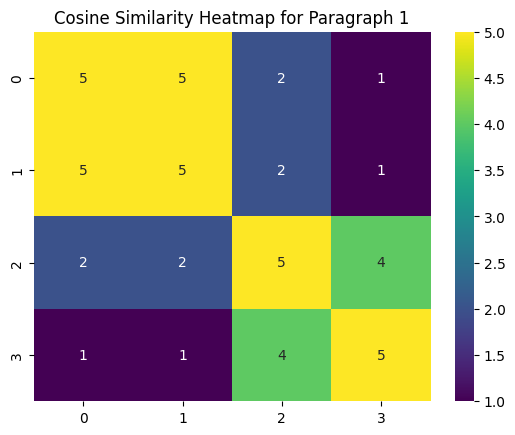

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affichage de la heatmap
sns.heatmap(submatrixc_1p, annot=True, cmap='viridis')
plt.title(f"Cosine Similarity Heatmap for Paragraph {1}")
plt.show()


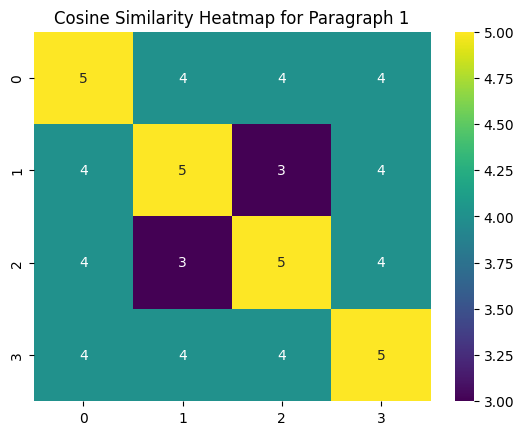

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affichage de la heatmap
sns.heatmap(submatrix_1p, annot=True, cmap='viridis')
plt.title(f"Cosine Similarity Heatmap for Paragraph {1}")
plt.show()


In [119]:
submatrixc_2p = coherence_matrix [4:8, 4:8]

print(f"First 4x4 Submatrix for Paragraph {2}:\n{submatrixc_2p}\n")
print(submatrixc_2p.mean())

First 4x4 Submatrix for Paragraph 2:
[[5 5 1 1]
 [5 5 1 1]
 [1 1 5 2]
 [1 1 2 5]]

2.625


In [120]:

submatrix_2p = normalized_similarity_matrix[4:8, 4:8]

print(f"First 4x4 Submatrix for Paragraph {2}:\n{submatrix_2p}\n")
print(submatrix_2p.mean())

First 4x4 Submatrix for Paragraph 2:
[[5. 3. 4. 3.]
 [3. 5. 3. 3.]
 [4. 3. 5. 4.]
 [3. 3. 4. 5.]]

3.75


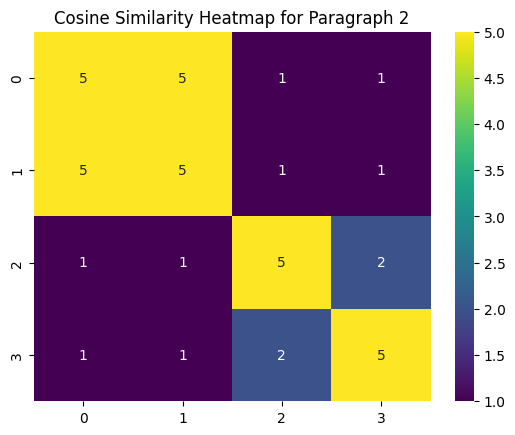

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affichage de la heatmap
sns.heatmap(submatrixc_2p, annot=True, cmap='viridis')
plt.title(f"Cosine Similarity Heatmap for Paragraph {2}")
plt.show()

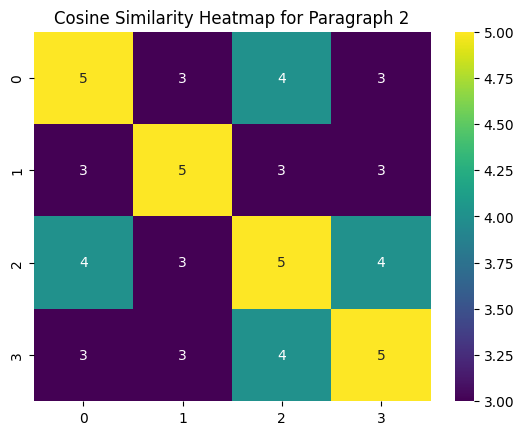

In [122]:
# Affichage de la heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Affichage de la heatmap
sns.heatmap(submatrix_2p, annot=True, cmap='viridis')
plt.title(f"Cosine Similarity Heatmap for Paragraph {2}")
plt.show()

In [123]:
submatrixc_3p = coherence_matrix [8:,8:]

print(f" 3x3 Submatrix for Paragraph {3}:\n{submatrixc_3p}\n")
print(submatrixc_3p.mean())

 3x3 Submatrix for Paragraph 3:
[[5 5 5]
 [5 5 5]
 [5 5 5]]

5.0


In [124]:

submatrix_3p = normalized_similarity_matrix[8:, 8:]

print(f"First 3x3 Submatrix for Paragraph {3}:\n{submatrix_3p}\n")
print(submatrix_3p.mean())

First 3x3 Submatrix for Paragraph 3:
[[5. 4. 4.]
 [4. 5. 4.]
 [4. 4. 5.]]

4.3333335


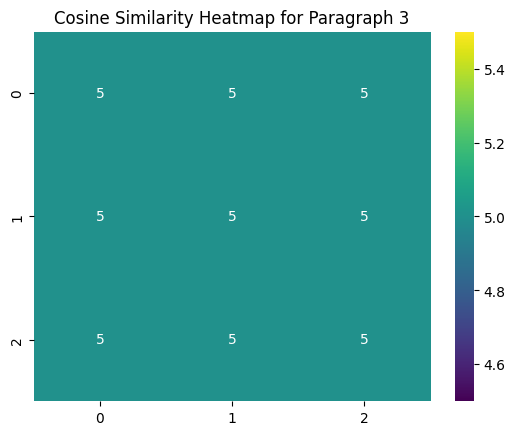

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affichage de la heatmap
sns.heatmap(submatrixc_3p, annot=True, cmap='viridis')
plt.title(f"Cosine Similarity Heatmap for Paragraph {3}")
plt.show()

In [126]:

submatrix_3p = normalized_similarity_matrix[8:, 8:]

print(f"First 3x3 Submatrix for Paragraph {3}:\n{submatrix_3p}\n")
print(submatrix_3p.mean())

First 3x3 Submatrix for Paragraph 3:
[[5. 4. 4.]
 [4. 5. 4.]
 [4. 4. 5.]]

4.3333335


Approche 3 :
Mesurer la cohérence des paires consécutives de phrases

In [127]:
dataframe['phrase1'] = dataframe['phrase1'].drop_duplicates(keep='first')
dataframe = dataframe.dropna()
dataframe
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

dataframe['phrase1_embeddings'] = dataframe['phrase1'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())
dataframe['phrase2_embeddings'] = dataframe['phrase2'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())
dataframe['manhattan_distance'] = dataframe.apply(lambda row: np.linalg.norm(row['phrase1_embeddings'] - row['phrase2_embeddings'], ord=1), axis=1)

# Calculate similarity based on Manhattan distance
dataframe['manhattan_similarity'] = 1 / (1 + dataframe['manhattan_distance'])

# Scale similarity values to the range [1, 5]
min_val_manhattan = dataframe['manhattan_similarity'].min()
max_val_manhattan = dataframe['manhattan_similarity'].max()
dataframe['manhattan_similarity'] = 1 + 4 * (dataframe['manhattan_similarity'] - min_val_manhattan) / (max_val_manhattan - min_val_manhattan)

# Round the scaled similarity values to the nearest integer
dataframe['manhattan_similarity'] = dataframe['manhattan_similarity'].round()
from sklearn.metrics.pairwise import cosine_similarity

dataframe['cosine_similarity'] = dataframe.apply(lambda row: cosine_similarity([row['phrase1_embeddings']], [row['phrase2_embeddings']])[0][0], axis=1)
# Scale similarity values to the range [1, 5]
min_val_cosine = dataframe['cosine_similarity'].min()
max_val_cosine = dataframe['cosine_similarity'].max()
dataframe['cosine_similarity'] = 1 + 4 * (dataframe['cosine_similarity'] - min_val_cosine) / (max_val_cosine - min_val_cosine)

# Round
dataframe['cosine_similarity'] = dataframe['cosine_similarity'].round()
dataframe['euclidean_distance'] = dataframe.apply(lambda row: np.linalg.norm(row['phrase1_embeddings'] - row['phrase2_embeddings']), axis=1)
# Calculate similarity as the inverse of the Euclidean distance
dataframe['euclidean_similarity'] = 1 / (1 + dataframe['euclidean_distance'])
# Scale similarity values to the range [1, 5]
min_val = dataframe['euclidean_similarity'].min()
max_val = dataframe['euclidean_similarity'].max()
dataframe['euclidean_similarity'] = 1 + 4 * (dataframe['euclidean_similarity'] - min_val) / (max_val - min_val)
dataframe['euclidean_similarity'] = dataframe['euclidean_similarity'].round()
Similarités_Phrases = dataframe.loc[:, ['Numéro de paragraphe', 'phrase1','phrase2','cosine_similarity','euclidean_similarity','manhattan_similarity','Note de cohérence']]
Similarités_Phrases


,Numéro de paragraphe,phrase1,phrase2,cosine_similarity,euclidean_similarity,manhattan_similarity,Note de cohérence
0,1,"In the realm of artificial intelligence, algor...","Concurrently, traditional programming languag...",4.0,3.0,3.0,4
4,1,"Concurrently, traditional programming languag...","As quantum computing edges closer to reality,...",3.0,2.0,2.0,4
7,1,"As quantum computing edges closer to reality,...","In the cybersecurity domain, digital defenses...",4.0,4.0,5.0,4
9,1,"In the cybersecurity domain, digital defenses...",While machine learning models analyze vast da...,5.0,5.0,5.0,3
10,2,The sun shines brightly in the clear blue sky,"Birds chirp happily in the trees, and a gentl...",4.0,2.0,2.0,5
16,2,"Birds chirp happily in the trees, and a gentl...","Children laugh and play in the nearby park, e...",5.0,3.0,4.0,3
20,2,"Children laugh and play in the nearby park, e...","A friendly dog runs around, chasing a ball th...",3.0,2.0,2.0,1
24,2,"A friendly dog runs around, chasing a ball th...","As the day unfolds, families gather for a pic...",3.0,2.0,1.0,1
27,2,"As the day unfolds, families gather for a pic...","In a distant city, skyscrapers tower over the...",3.0,2.0,2.0,1
29,2,"In a distant city, skyscrapers tower over the...","Meanwhile, a chef in a small restaurant passi...",3.0,2.0,2.0,2


# ***Coherence Entre Pargraphes***

***Approche 1***

In [128]:
submatrixc_1p3 = coherence_matrix [:4,8:]

print(f" 3x4 Submatrix for Paragraph {3}:\n{submatrixc_1p3}\n")
print(submatrixc_1p3.mean())

 3x4 Submatrix for Paragraph 3:
[[1 1 1]
 [1 1 1]
 [2 1 1]
 [1 1 1]]

1.0833333333333333


In [129]:

submatrix_1p3 = normalized_similarity_matrix[:4, 8:]

print(f"First 4x3 Submatrix for Paragraph {i}:\n{submatrix_1p3}\n")
print(submatrix_1p3.mean())

First 4x3 Submatrix for Paragraph 10:
[[4. 4. 4.]
 [4. 4. 4.]
 [3. 3. 3.]
 [4. 4. 3.]]

3.6666667


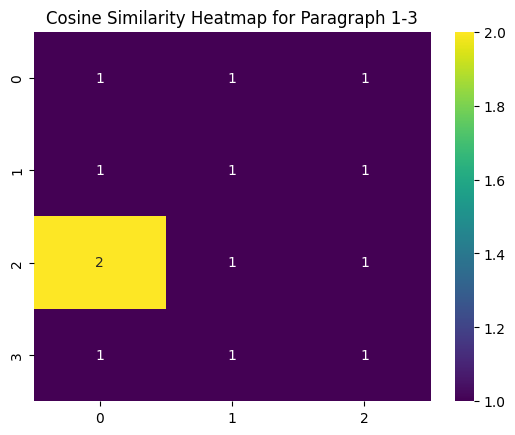

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affichage de la heatmap
sns.heatmap(submatrixc_1p3, annot=True, cmap='viridis')
plt.title(f"Cosine Similarity Heatmap for Paragraph {1}-{3}")
plt.show()

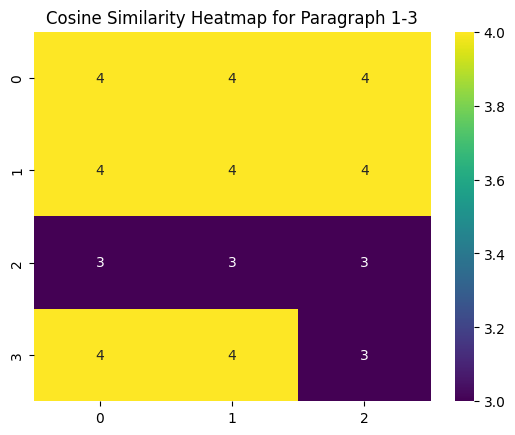

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affichage de la heatmap
sns.heatmap(submatrix_1p3, annot=True, cmap='viridis')
plt.title(f"Cosine Similarity Heatmap for Paragraph {1}-{3}")
plt.show()

In [132]:
submatrixc_1p2 = coherence_matrix [:4,4:8]

print(f" 4x4 Submatrix for Paragraph {1}-{2}:\n{submatrixc_1p2}\n")
print(submatrixc_1p2.mean())

 4x4 Submatrix for Paragraph 1-2:
[[1 1 5 2]
 [1 1 5 2]
 [1 1 2 5]
 [1 1 2 4]]

2.1875


In [133]:

submatrix_1p2 = normalized_similarity_matrix[:4,4:8]

print(f"First 4x4 Submatrix for Paragraph {1}-{2}:\n{submatrix_1p2}\n")
print(submatrix_1p2.mean())


First 4x4 Submatrix for Paragraph 1-2:
[[4. 3. 4. 4.]
 [4. 3. 4. 4.]
 [4. 3. 3. 4.]
 [4. 3. 4. 4.]]

3.6875


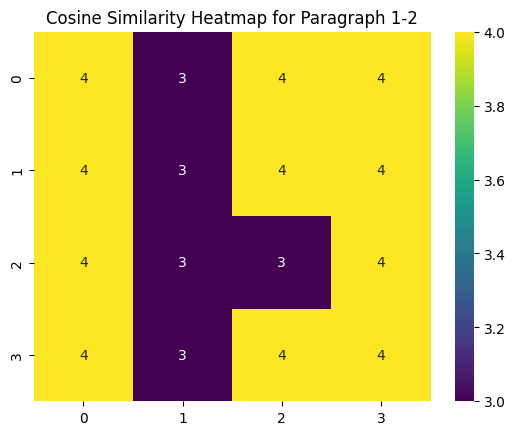

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affichage de la heatmap
sns.heatmap(submatrix_1p2, annot=True, cmap='viridis')
plt.title(f"Cosine Similarity Heatmap for Paragraph {1}-{2}")
plt.show()

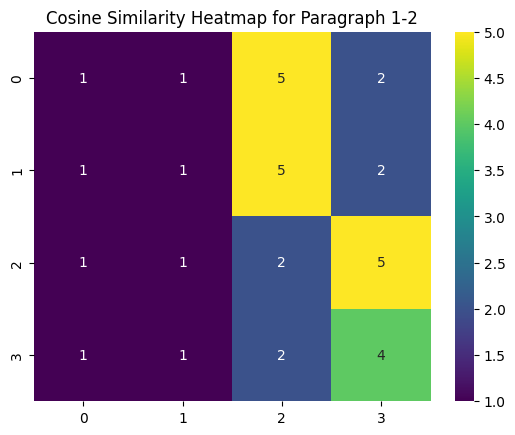

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affichage de la heatmap
sns.heatmap(submatrixc_1p2, annot=True, cmap='viridis')
plt.title(f"Cosine Similarity Heatmap for Paragraph {1}-{2}")
plt.show()

In [136]:

submatrix_2p3 = coherence_matrix[:4,4:8]

print(f"First 4x4 Submatrix for Paragraph {2}-{3}:\n{submatrix_1p2}\n")
print(submatrix_1p2.mean())

First 4x4 Submatrix for Paragraph 2-3:
[[4. 3. 4. 4.]
 [4. 3. 4. 4.]
 [4. 3. 3. 4.]
 [4. 3. 4. 4.]]

3.6875


In [137]:

submatrix_2p3 = normalized_similarity_matrix[4:8, 8:]

print(f"First 3x3 Submatrix for Paragraph {2}-{3}:\n{submatrix_2p3}\n")
print(submatrix_2p3.mean())

First 3x3 Submatrix for Paragraph 2-3:
[[4. 4. 4.]
 [3. 3. 3.]
 [4. 4. 4.]
 [4. 3. 4.]]

3.6666667


***Approche 2***

In [138]:
import numpy as np

# Fonction pour obtenir l'index de l'argmax des vecteurs propres
def get_max_eigenvalue_index(submatrix):
    # Calcul des valeurs propres et vecteurs propres
    eigenvalues, eigenvectors = np.linalg.eig(submatrix)

    print(eigenvalues)

    # Index de l'argmax des vecteurs propres
    max_eigenvalue_index = np.argmax(eigenvalues)

    return max_eigenvalue_index



In [139]:
# Utilisation de la fonction avec submatrix_1p
index_max_eigenvalue = get_max_eigenvalue_index(submatrix_1p)

# Affichage du résultat
print(f"Index of max eigenvalue for Submatrix 1: {index_max_eigenvalue}")



[16.51561     0.48439023  1.          2.        ]
Index of max eigenvalue for Submatrix 1: 0


In [140]:
# Utilisation de la fonction avec submatrix_1p
index_max_eigenvalue = get_max_eigenvalue_index(submatrix_2p)

# Affichage du résultat
print(f"Index of max eigenvalue for Submatrix 2: {index_max_eigenvalue}")



[15.038453   0.6265056  2.         2.3350413]
Index of max eigenvalue for Submatrix 2: 0


In [141]:
# Utilisation de la fonction avec submatrix_1p
index_max_eigenvalue = get_max_eigenvalue_index(submatrix_3p)

# Affichage du résultat
print(f"Index of max eigenvalue for Submatrix 3: {index_max_eigenvalue}")



[ 1. 13.  1.]
Index of max eigenvalue for Submatrix 3: 1


In [142]:
# Coherence entre paragraphe 1 et 2
normalized_similarity_matrix[get_max_eigenvalue_index(submatrix_1p)][get_max_eigenvalue_index(submatrix_2p)+4]


[16.51561     0.48439023  1.          2.        ]
[15.038453   0.6265056  2.         2.3350413]


4.0

In [143]:
## Coherence entre paragraphe 1 et 3
normalized_similarity_matrix[get_max_eigenvalue_index(submatrix_1p)][get_max_eigenvalue_index(submatrix_3p)+8]


[16.51561     0.48439023  1.          2.        ]
[ 1. 13.  1.]


4.0

In [144]:
# Coherence entre paragraphe 2 et 3
normalized_similarity_matrix[get_max_eigenvalue_index(submatrix_2p)+4][get_max_eigenvalue_index(submatrix_3p)+8]


[15.038453   0.6265056  2.         2.3350413]
[ 1. 13.  1.]


4.0

Approche 3 : Mesuer la cohérence entre les paraghraphes successives

In [145]:
import pandas as pd

# Grouper le dataframe par 'Numéro de paragraphe' et concaténer les phrases
df_groupe = dataframe.groupby('Numéro de paragraphe').agg({
    'phrase1': ' '.join,  # Concaténer les phrases de 'phrase1'

}).reset_index()

df_groupe.rename(columns={'phrase1': 'paragraphe'}, inplace=True)
df_groupe
from sklearn.metrics.pairwise import pairwise_distances
df_groupe['vectors']=df_groupe['paragraphe'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state.mean(dim=1).squeeze().detach().numpy())
vectors = df_groupe['vectors'].values


similarities = []
# Boucle pour comparer chaque paire de paragraphes
for i in range(1, 10):
    for j in range(i+1, 10):  # Assurez-vous que j > i pour avoir des paires distinctes
        vector_i = vectors[i-1]  # Soustraire 1 car les indices commencent à 0
        vector_j = vectors[j-1]

        # Calculer la similarité cosinus
        similarity = cosine_similarity([vector_i], [vector_j])[0][0]

        # Ajouter les informations à la liste
        similarities.append({
            'Paragraphe_i': i,
            'Paragraphe_j': j,
            'Similarité_cosinus': similarity
        })

# Créer un dataframe à partir de la liste
similarities_df = pd.DataFrame(similarities)
min_val_cosine = similarities_df['Similarité_cosinus'].min()
max_val_cosine = similarities_df['Similarité_cosinus'].max()
similarities_df['Similarité_cosinus'] = 1 + 4 * (similarities_df['Similarité_cosinus'] - min_val_cosine) / (max_val_cosine - min_val_cosine)

# Round the scaled similarity values to the nearest integer
similarities_df['Similarité_cosinus'] = similarities_df['Similarité_cosinus'].round()
similarities_df
similarities_df['Paragraphe_i'] = similarities_df['Paragraphe_i'].drop_duplicates(keep='first')
similarities_df = similarities_df.dropna()
similarities_df


,Paragraphe_i,Paragraphe_j,Similarité_cosinus
0,1.0,2,3.0
8,2.0,3,2.0
15,3.0,4,4.0
21,4.0,5,4.0
26,5.0,6,4.0
30,6.0,7,4.0
33,7.0,8,5.0
35,8.0,9,3.0


# ***Coherence dans le Texte***

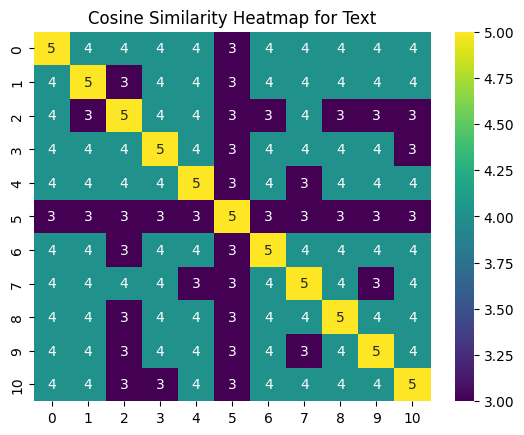

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Affichage de la heatmap
sns.heatmap(normalized_similarity_matrix, annot=True, cmap='viridis')
plt.title(f"Cosine Similarity Heatmap for Text")
plt.show()


In [176]:
print(normalized_similarity_matrix.mean())
dataframe['sentence'] = dataframe.apply(lambda row: row['phrase1'] + ' ' + row['phrase2'], axis=1)
data=dataframe

3.7933884


#Question Bonus

Prétraitement des données


In [177]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def preprocess_text_column(dataframe, text_column, text_column_2):
    # Convert the text column to lowercase
    dataframe[text_column] = dataframe[text_column].str.lower()

    # Remove special characters, numbers, and punctuation
    dataframe[text_column] = dataframe[text_column].apply(lambda text: re.sub(r'\d+', '', text))  # Remove numbers
    dataframe[text_column] = dataframe[text_column].apply(lambda text: re.sub(r'[^\w\s]', '', text))  # Remove special characters and punctuation

    # Tokenize the text
    dataframe[text_column] = dataframe[text_column].apply(lambda text: word_tokenize(text))

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    dataframe[text_column] = dataframe[text_column].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    dataframe[text_column_2] = dataframe[text_column].apply(lambda tokens: [token for token in tokens if token not in stop_words])

    # Join tokens back into a single string
    dataframe[text_column] = dataframe[text_column].apply(lambda tokens: ' '.join(tokens))
    dataframe[text_column] = dataframe[text_column].apply(lambda text: re.sub(r'\s+', ' ', text))

    return dataframe

# Example usage
preprocess_text_column(data, 'sentence', 'tokenized_text')
dataframe


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Numéro de paragraphe,Note de cohérence,phrase1,phrase2,sentence,tokenized_text
0,1,4,"In the realm of artificial intelligence, algor...","Concurrently, traditional programming languag...",in the realm of artificial intelligence algori...,"[realm, artificial, intelligence, algorithm, d..."
1,1,3,"In the realm of artificial intelligence, algor...","As quantum computing edges closer to reality,...",in the realm of artificial intelligence algori...,"[realm, artificial, intelligence, algorithm, d..."
2,1,2,"In the realm of artificial intelligence, algor...","In the cybersecurity domain, digital defenses...",in the realm of artificial intelligence algori...,"[realm, artificial, intelligence, algorithm, d..."
3,1,2,"In the realm of artificial intelligence, algor...",While machine learning models analyze vast da...,in the realm of artificial intelligence algori...,"[realm, artificial, intelligence, algorithm, d..."
4,1,4,"Concurrently, traditional programming languag...","As quantum computing edges closer to reality,...",concurrently traditional programming language ...,"[concurrently, traditional, programming, langu..."
...,...,...,...,...,...,...
92,9,1,The cat caught a mouse,The school's science fair showcases projects ...,the cat caught a mouse the school science fair...,"[cat, caught, mouse, school, science, fair, sh..."
93,9,1,The cat caught a mouse,"As the bell rings, signaling the end of the d...",the cat caught a mouse a the bell ring signali...,"[cat, caught, mouse, bell, ring, signaling, en..."
94,9,4,"Amid the chalkboard equations, a glimpse of th...",The school's science fair showcases projects ...,amid the chalkboard equation a glimpse of the ...,"[amid, chalkboard, equation, glimpse, future, ..."
95,9,3,"Amid the chalkboard equations, a glimpse of th...","As the bell rings, signaling the end of the d...",amid the chalkboard equation a glimpse of the ...,"[amid, chalkboard, equation, glimpse, future, ..."


Train test split


In [178]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['sentence'], data['Note de cohérence'], test_size=0.2, random_state=42)

Bag of words vectoriser


In [179]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train).toarray()
X_test_bow = count_vectorizer.transform(X_test).toarray()


TF IDF vectoriser

In [180]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

Word2Vec vectoriser

In [181]:
from gensim.models import Word2Vec
# Train Word2Vec model
model = Word2Vec(sentences=data['tokenized_text'].tolist(), vector_size=100, window=5, min_count=1, workers=4)

# Save the model
model.save("word2vec_model")

# Load the model
loaded_model = Word2Vec.load("word2vec_model")

# Apply Word2Vec to the 'text' column
data['word2vec'] = data['tokenized_text'].apply(lambda x: np.mean([loaded_model.wv[word] for word in x], axis=0))

X_train_word2vec, X_test_word2vec, y_train, y_test = train_test_split(data['word2vec'].tolist(), data['Note de cohérence'], test_size=0.2, random_state=42)


# Display the DataFrame with Word2Vec embeddings
print(data)

    Numéro de paragraphe  Note de cohérence  \
0                      1                  4   
1                      1                  3   
2                      1                  2   
3                      1                  2   
4                      1                  4   
..                   ...                ...   
92                     9                  1   
93                     9                  1   
94                     9                  4   
95                     9                  3   
96                     9                  3   

                                              phrase1  \
0   In the realm of artificial intelligence, algor...   
1   In the realm of artificial intelligence, algor...   
2   In the realm of artificial intelligence, algor...   
3   In the realm of artificial intelligence, algor...   
4    Concurrently, traditional programming languag...   
..                                                ...   
92                             The c

Naive Bayes with Bag of Words

In [185]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.metrics import confusion_matrix

nb_bow = GaussianNB()
nb_bow.fit(X_train_bow, y_train)
y_pred_nb_bow = nb_bow.predict(X_test_bow)
# Confusion Matrix
conf_matrix_nb_bow = confusion_matrix(y_test, y_pred_nb_bow)
print("Confusion Matrix:")
print(conf_matrix_nb_bow)

# Precision, Recall, and Accuracy
precision_nb_bow = precision_score(y_test, y_pred_nb_bow, average='weighted')
recall_nb_bow = recall_score(y_test, y_pred_nb_bow, average='weighted')
accuracy_nb_bow = accuracy_score(y_test, y_pred_nb_bow)
f1_nb_bow = f1_score(y_test, y_pred_nb_bow, average='weighted')


print(f"\nGaussian Naive Bayes with Bag of Words Metrics:")
print(f"Precision: {precision_nb_bow}")
print(f"Recall: {recall_nb_bow}")
print(f"Accuracy: {accuracy_nb_bow}")
print(f"F1 Score: {f1_nb_bow}")

Confusion Matrix:
[[0 4 0 1 1]
 [2 0 1 0 0]
 [1 0 1 0 0]
 [2 2 1 1 0]
 [1 1 0 0 1]]

Gaussian Naive Bayes with Bag of Words Metrics:
Precision: 0.2583333333333333
Recall: 0.15
Accuracy: 0.15
F1 Score: 0.175


Naive Bayes with TF-IDF

In [186]:
nb_tfidf = GaussianNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)
# Confusion Matrix
conf_matrix_nb_tfidf = confusion_matrix(y_test, y_pred_nb_tfidf)
print("Confusion Matrix:")
print(conf_matrix_nb_tfidf)

# Precision, Recall, and Accuracy
precision_nb_tfidf = precision_score(y_test, y_pred_nb_tfidf, average='weighted')
recall_nb_tfidf = recall_score(y_test, y_pred_nb_tfidf, average='weighted')
accuracy_nb_tfidf = accuracy_score(y_test, y_pred_nb_tfidf)
f1_nb_tfidf = f1_score(y_test, y_pred_nb_tfidf, average='weighted')


print(f"\nGaussian Naive Bayes with TF-IDF Metrics:")
print(f"Precision: {precision_nb_tfidf}")
print(f"Recall: {recall_nb_tfidf}")
print(f"Accuracy: {accuracy_nb_tfidf}")
print(f"F1 Score: {f1_nb_tfidf}")

Confusion Matrix:
[[0 4 0 1 1]
 [2 0 1 0 0]
 [1 0 1 0 0]
 [2 2 1 1 0]
 [1 1 0 0 1]]

Gaussian Naive Bayes with TF-IDF Metrics:
Precision: 0.2583333333333333
Recall: 0.15
Accuracy: 0.15
F1 Score: 0.175


Naive Bayes with word2vec

In [187]:
nb_word2vec = GaussianNB()
nb_word2vec.fit(X_train_word2vec, y_train)
y_pred_nb_word2vec = nb_word2vec.predict(X_test_word2vec)
# Confusion Matrix
conf_matrix_nb_word2vec= confusion_matrix(y_test, y_pred_nb_word2vec)
print("Confusion Matrix:")
print(conf_matrix_nb_word2vec)

# Precision, Recall, and Accuracy
precision_nb_word2vec = precision_score(y_test, y_pred_nb_word2vec, average='weighted')
recall_nb_word2vec = recall_score(y_test, y_pred_nb_word2vec, average='weighted')
accuracy_nb_word2vec = accuracy_score(y_test, y_pred_nb_word2vec)
f1_nb_word2vec = f1_score(y_test, y_pred_nb_word2vec, average='weighted')

print(f"\nGaussian Naive Bayes with word2vec Metrics:")
print(f"Precision: {precision_nb_word2vec}")
print(f"Recall: {recall_nb_word2vec}")
print(f"Accuracy: {accuracy_nb_word2vec}")
print(f"F1 Score: {f1_nb_word2vec}")

Confusion Matrix:
[[2 2 2 0 0]
 [2 0 1 0 0]
 [0 1 1 0 0]
 [3 1 2 0 0]
 [1 1 0 0 1]]

Gaussian Naive Bayes with word2vec Metrics:
Precision: 0.24166666666666664
Recall: 0.2
Accuracy: 0.2
F1 Score: 0.18571428571428572


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM with bag of words

In [188]:
from sklearn.svm import SVC
svm_bow = SVC()
svm_bow.fit(X_train_bow, y_train)
y_pred_svm_bow = svm_bow.predict(X_test_bow)
# Confusion Matrix
conf_matrix_svm_bow= confusion_matrix(y_test, y_pred_svm_bow)
print("Confusion Matrix:")
print(conf_matrix_svm_bow)

# Precision, Recall, and Accuracy
precision_svm_bow = precision_score(y_test, y_pred_svm_bow, average='weighted')
recall_svm_bow = recall_score(y_test, y_pred_svm_bow, average='weighted')
accuracy_svm_bow = accuracy_score(y_test, y_pred_svm_bow)
f1_svm_bow = f1_score(y_test, y_pred_svm_bow, average='weighted')

print(f"\nSVM with bag of words Metrics:")
print(f"Precision: {precision_svm_bow}")
print(f"Recall: {recall_svm_bow}")
print(f"Accuracy: {accuracy_svm_bow}")
print(f"F1 Score: {f1_svm_bow}")

Confusion Matrix:
[[5 0 1 0 0]
 [3 0 0 0 0]
 [1 0 1 0 0]
 [5 0 1 0 0]
 [3 0 0 0 0]]

SVM with bag of words Metrics:
Precision: 0.12156862745098038
Recall: 0.3
Accuracy: 0.3
F1 Score: 0.17043478260869566


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM with TF-IDF

In [189]:
svm_tfidf = SVC()
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)
# Confusion Matrix
conf_matrix_svm_tfidf = confusion_matrix(y_test, y_pred_svm_tfidf)
print("Confusion Matrix:")
print(conf_matrix_svm_tfidf)

# Precision, Recall, and Accuracy
precision_svm_tfidf = precision_score(y_test, y_pred_svm_tfidf, average='weighted')
recall_svm_tfidf = recall_score(y_test, y_pred_svm_tfidf, average='weighted')
accuracy_svm_tfidf = accuracy_score(y_test, y_pred_svm_tfidf)
f1_svm_tfidf = f1_score(y_test, y_pred_svm_tfidf, average='weighted')

print(f"\nSVM with TF-IDF Metrics:")
print(f"Precision: {precision_svm_tfidf}")
print(f"Recall: {recall_svm_tfidf}")
print(f"Accuracy: {accuracy_svm_tfidf}")
print(f"F1 Score: {f1_svm_tfidf}")

Confusion Matrix:
[[5 0 1 0 0]
 [2 0 1 0 0]
 [1 0 1 0 0]
 [3 0 3 0 0]
 [3 0 0 0 0]]

SVM with TF-IDF Metrics:
Precision: 0.12380952380952381
Recall: 0.3
Accuracy: 0.3
F1 Score: 0.175


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM with word2Vec

In [190]:
svm_word2vec = SVC()
svm_word2vec.fit(X_train_word2vec, y_train)
y_pred_svm_word2vec = svm_word2vec.predict(X_test_word2vec)
# Confusion Matrix
conf_matrix_svm_word2vec = confusion_matrix(y_test, y_pred_svm_word2vec)
print("Confusion Matrix:")
print(conf_matrix_svm_word2vec)

# Precision, Recall, and Accuracy
precision_svm_word2vec = precision_score(y_test, y_pred_svm_word2vec, average='weighted')
recall_svm_word2vec = recall_score(y_test, y_pred_svm_word2vec, average='weighted')
accuracy_svm_word2vec = accuracy_score(y_test, y_pred_svm_word2vec)
f1_svm_word2vec = f1_score(y_test, y_pred_svm_word2vec, average='weighted')

print(f"\nSVM with word2Vec Metrics:")
print(f"Precision: {precision_svm_word2vec}")
print(f"Recall: {recall_svm_word2vec}")
print(f"Accuracy: {accuracy_svm_word2vec}")
print(f"F1 Score: {f1_svm_word2vec}")

Confusion Matrix:
[[4 0 2 0 0]
 [3 0 0 0 0]
 [1 0 1 0 0]
 [3 0 3 0 0]
 [3 0 0 0 0]]

SVM with word2Vec Metrics:
Precision: 0.10238095238095238
Recall: 0.25
Accuracy: 0.25
F1 Score: 0.14500000000000002


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
